# Optogenetics

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Synaptic_currents" folder

In [23]:
data_folder = "data/9-Opto"

from glob import glob
data_files = glob(data_folder+"/*.abf")
data_files.sort()
print(data_folder)
data_files

data/9-Opto


['data/9-Opto/2024_06_18_0013.abf',
 'data/9-Opto/2024_06_18_0014.abf',
 'data/9-Opto/2024_06_18_0015.abf',
 'data/9-Opto/2024_06_18_0016.abf',
 'data/9-Opto/2024_06_18_0017.abf',
 'data/9-Opto/2024_06_18_0018.abf',
 'data/9-Opto/2024_06_18_0019.abf',
 'data/9-Opto/2024_06_18_0020.abf',
 'data/9-Opto/2024_06_18_0021.abf',
 'data/9-Opto/2024_06_18_0023.abf',
 'data/9-Opto/2024_06_18_0025.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [52]:
data_file = 'data/9-Opto/2024_06_18_0025.abf'

Now we can load the file and plot the raw data:

Trace('2024_06_18_0025.abf')
Number of sweeps: 14
Points per sweep: 26,000
Duration per sweep: 2.600 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL
Voltage step time: [540.6] to [2040.6] ms


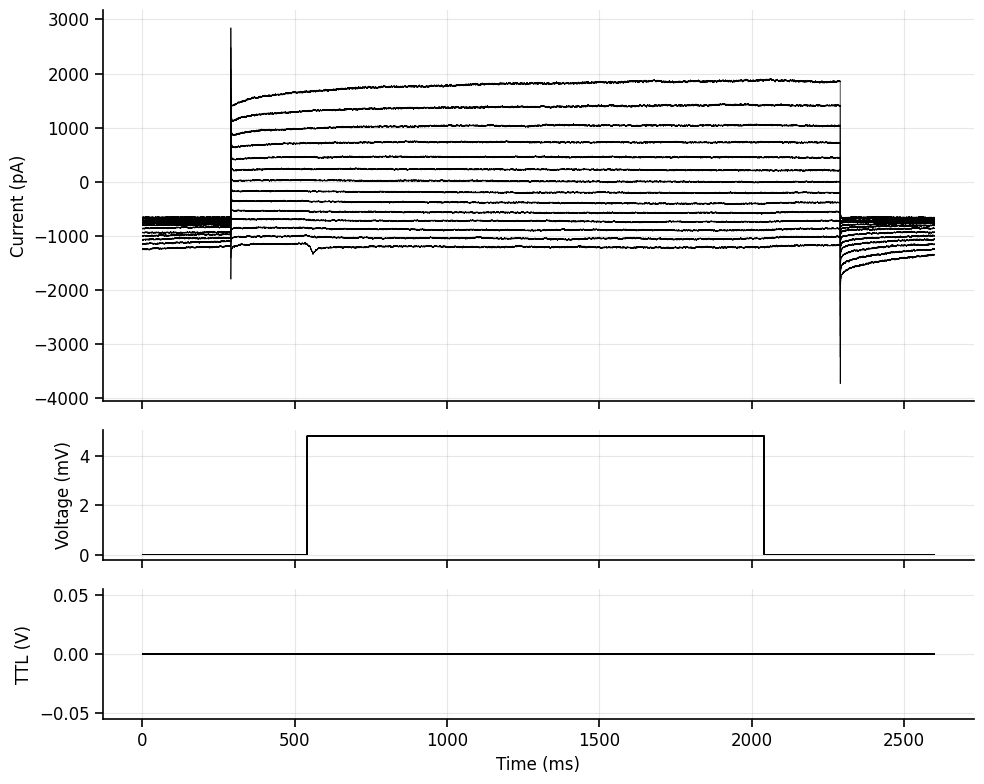

In [53]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
# %matplotlib widget
%matplotlib inline
traces.plot(plot_ttl=True, plot_voltage=True, sweep='all', time_units='ms')

v_step_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+1, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
v_step_end = traces.get_step_events(threshold=traces.voltage_data[0,-1]+1, channel='voltage', edge='falling', polarity='positive', time_units=time_units, sweep=0)
print(f"Voltage step time: {v_step_start} to {v_step_end} ms")
x_axis_range = (v_step_start[0]-50, v_step_end[0]+50)

plt.show()

## 2. Signal processing

To make measurements easier, we will first crop the traces around the light stimulus.

In [54]:
traces = traces.crop(timepoint=x_axis_range[0], timepoint_2=x_axis_range[1], time_units=time_units)
opto_start = 50
opto_end = x_axis_range[1] - x_axis_range[0] - 50
print(f"Opto stimulation time: {opto_start} to {opto_end:.2f} ms")

Opto stimulation time: 50 to 1550.00 ms


### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-1144.4514  -998.6841  -848.9562 ...   977.7884  1295.6686  1654.3967]


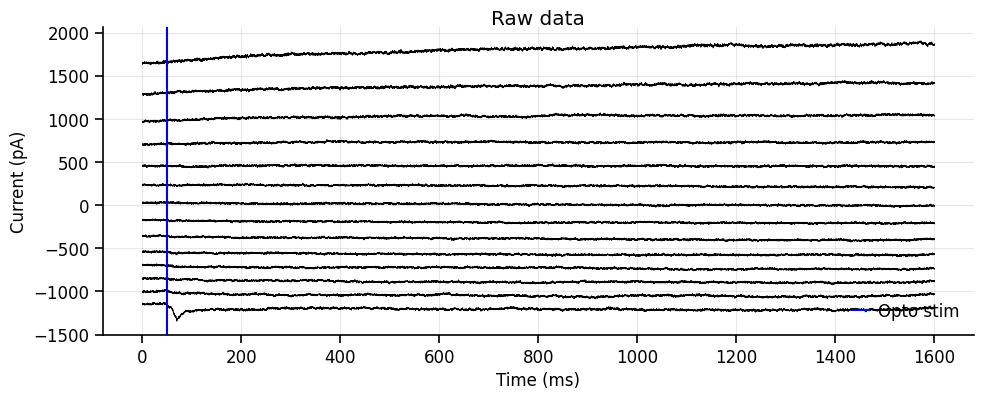

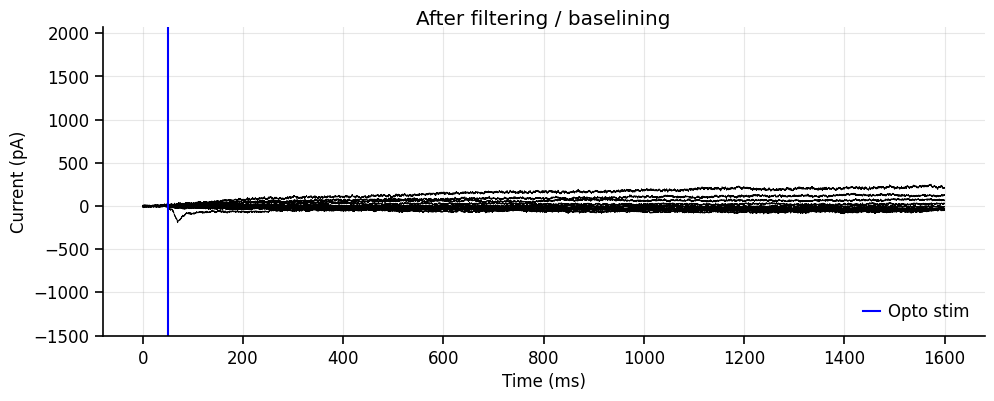

In [55]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = True  # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1, apply_to_voltage=False)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = 0  # Start time for baseline subtraction
    end_baseline = 50  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.axvline(opto_start, color='blue', label='Opto stim')
    ax.legend(loc='lower right', handlelength=1, handletextpad=0.5)
    ax.set_title('Raw data', y=0.98)
    ylims = ax.get_ylim()
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering / baselining', y=0.98)
    ax.axvline(opto_start, color='blue', label='Opto stim')
    ax.legend(loc='lower right', handlelength=1, handletextpad=0.5)
    ax.set_ylim(ylims)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [56]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure the peak and steady-state current in each voltage step

First we will define the time window where we want to measure the peak currents

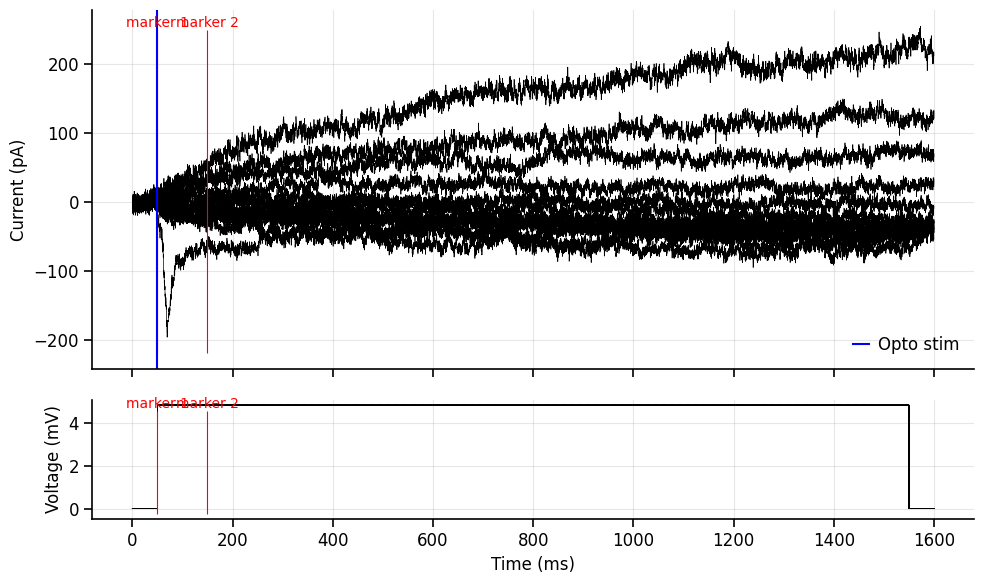

In [57]:
# The markers here will define the window where we will measure peak current values. If they don't look right you can adjust them to make sure you include all the current peaks without the stim artifact.
marker_1 = opto_start
marker_2 = opto_start + 100

# ----------------------------------------------------------------------------------------------------------------------
# change to %matplotlib inline if the interactive plot is not showing
%matplotlib inline
# %matplotlib widget   
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.axvline(opto_start, color='blue', label='Opto stim')
ax1.legend(loc='lower right', handlelength=1, handletextpad=0.5)
plt.show()

Now we can use the timepoints from the markers we defined above to measure the peak current for each voltage step.

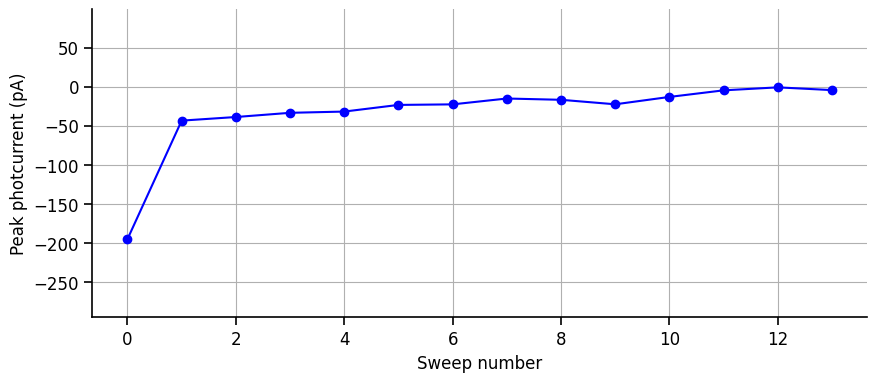

In [58]:
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'

peak_currents,_ = traces.get_measurements(start_time=marker_1, end_time=marker_2, measurement_type=measurement_type, time_units=time_units)

fig,ax = plt.subplots(figsize=(10, 4))
ax.plot(peak_currents, 'o-', label='Peak currents', color='blue')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Peak photcurrent (pA)')
ax.grid()
ax.set_ylim(np.min(peak_currents)-100, np.max(peak_currents)+100)
plt.show()

Now let's do the same to measure the steady-state currents

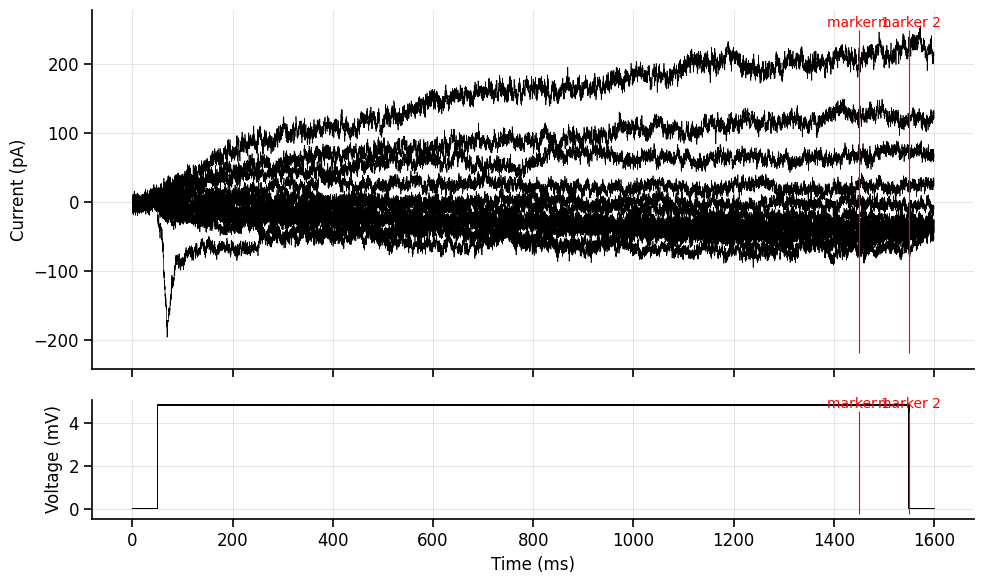

In [59]:
# The markers here will define the window where we will measure peak current values. If they don't look right you can adjust them to make sure you include all the current peaks without the stim artifact.
marker_3 = opto_end - 100
marker_4 = opto_end

# ----------------------------------------------------------------------------------------------------------------------
# change to %matplotlib inline if the interactive plot is not showing
%matplotlib inline
# %matplotlib widget   
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_3, marker_2=marker_4, sweep='all')
plt.show()

We will use the timepoints from the markers we defined above to measure the steady-state current for each voltage step.

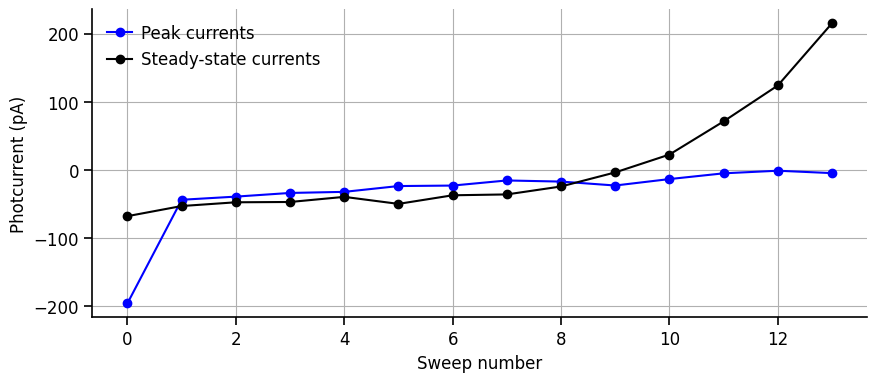

In [60]:
measurement_type = 'mean' # Options: 'mean', 'max', 'min', 'peak'

steady_state_currents,_ = traces.get_measurements(start_time=marker_3, end_time=marker_4, measurement_type=measurement_type, time_units=time_units)

fig,ax = plt.subplots(figsize=(10, 4))
ax.plot(peak_currents, 'o-', label='Peak currents', color='blue')
ax.plot(steady_state_currents, 'o-', label='Steady-state currents', color='black')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Photcurrent (pA)')
ax.grid()
ax.legend(handlelength=1.5, handletextpad=0.5, loc='upper left')
plt.show()